# Basic Needs Basic Rights Kenya - Tech4MentalHealth (Zindi Hackathon)


![Alt text](https://assets.zindi.africa/media/00aa4a928f3c44f881834d47fe624d91.png)


### context :

Around 1 in 4 people will experience a mental health problem this year. Low-income countries have an estimated treatment gap of 85% (as compared with high-income countries with a gap of 35% to 50%). While Kenya has a mental illness prevalence rate that is comparable to that of high-income countries, there are still less than 500 healthcare professionals serving the country.

In Kenya, there are growing concerns about mental health among young people, particularly university students that face a challenging and unique conflation of stressors that put them at risk of challenges like depression and substance abuse.

From the use of app-based solutions for screening to electronically delivered therapies, the use of technologies including machine learning and AI will potentially transform the delivery of mental health services in the coming years.

The objective of this challenge is to develop a machine learning model that classifies statements and questions expressed by university students in Kenya when speaking about the mental health challenges they struggle with. The four categories are depression, suicide, alchoholism, and drug abuse.

This solution will be used for a prototype of a mental health chatbot designed specifically for university students. This initiative is a first step in leveraging technology to make mental health services more accessible and more user-friendly for young people in Kenya and around the world.

![Atl text](https://zindpublic.blob.core.windows.net/public/uploads/image_attachment/image/393/24364b84-71d1-4f15-a8a2-4fae8e94fc39.png)

This challenge is sponsored by Basic Needs Basic Rights (BNBR) Kenya. BNBR supports people with or at increased risk of mental health problems to live and work successfully in their communities by facilitating access to mental health care and social support services.


### Objective :

Classify text from university students in Kenya towards a mental health chatbot


### Data Description :

The data consists of statements and questions expressed by students from multiple universities across Kenya who reported suffering from these different mental health challenges.

The wording of the statements is intended to respond to the prompting question, “What is on your mind?”

The labels for the training set are contained in Train.csv, corresponding to one of the four categories of mental health problems (depression, suicide, alchoholism, and drug abuse). Your task is to develop a machine learning model to predict the labels for the test set, following the format in sample_submission.csv.


In [53]:
#Importing the required Libraries
import numpy as np
import pandas as pd 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import SGDClassifier

In [54]:
path='./Train.csv'
path1='./Test.csv'

In [55]:
train=pd.read_csv(path)
train

,ID,Text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression
...,...,...,...
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol
612,GVDXRQPY,How to become my oldself again,Suicide
613,IO4JHIQS,How can someone stop it?,Alcohol
614,1DS3P1XO,I feel unworthy,Depression


In [56]:
test=pd.read_csv(path1)
test

,ID,Text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
...,...,...
304,Z9A6ACLK,Yes
305,ZDUOIGKN,My girlfriend dumped me
306,ZHQ60CCH,How can I go back to being my old self?
307,ZVIJMA4O,Is it true bhang is medicinal?


In [57]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Wordcloud Function

In [58]:
from wordcloud import WordCloud

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    




In [59]:
train['label'].value_counts()
#data=train[train['label']=='Depression']

Depression    352
Alcohol       140
Suicide        66
Drugs          58
Name: label, dtype: int64

## Most commonwords in Depression related statement

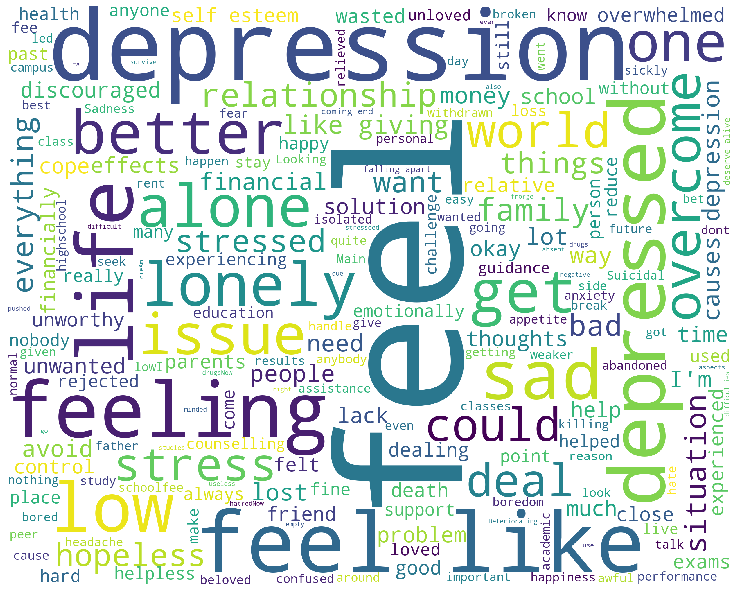

In [60]:
data=train[train['label']=='Depression']
A=data['Text']
wordcloud_draw(A, color = 'white')

## Most common words found in drugs related statement

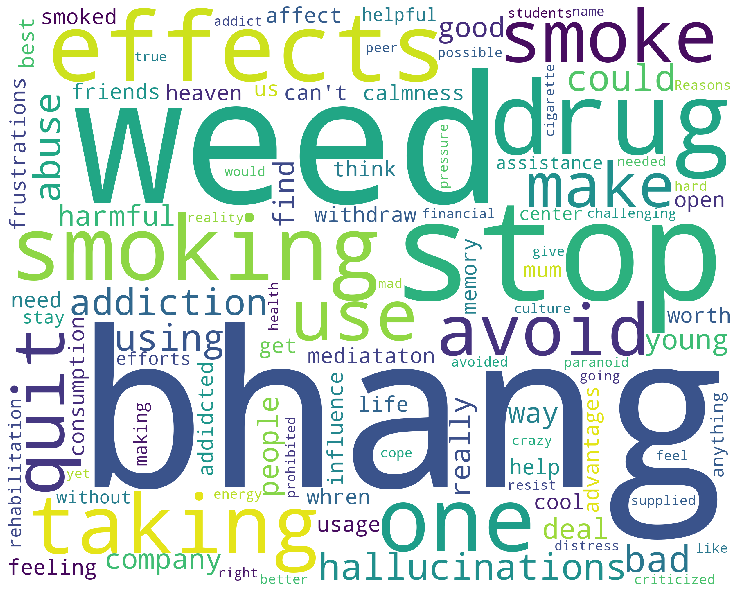

In [61]:
data=train[train['label']=='Drugs']
A=data['Text']
wordcloud_draw(A, color = 'white')

## Most Common words related to alcohol related statements

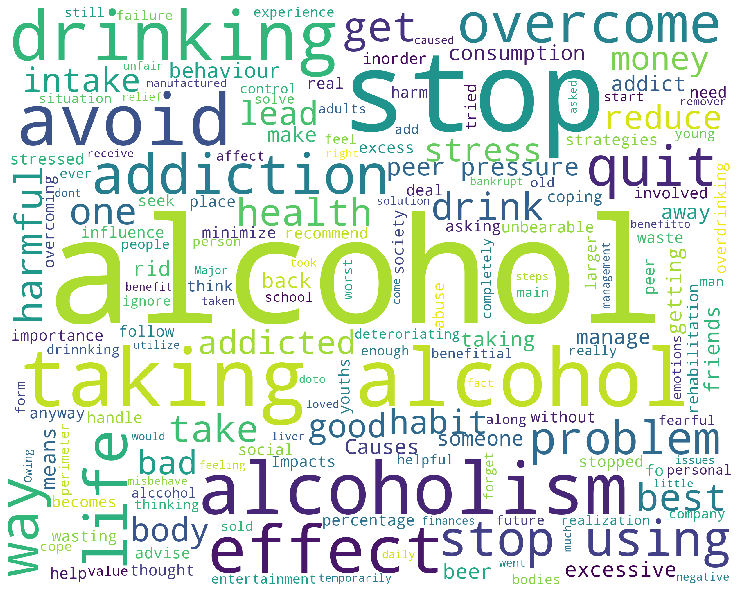

In [62]:
data=train[train['label']=='Alcohol']
A=data['Text']
wordcloud_draw(A, color = 'white')

## Most Common words related to suicide

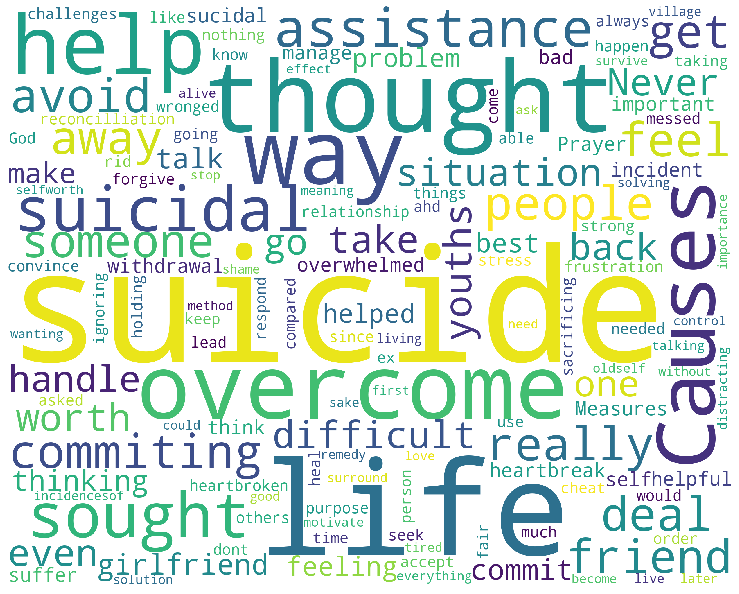

In [63]:
data=train[train['label']=='Suicide']
A=data['Text']
wordcloud_draw(A, color = 'white')

## Feature Engineering

In [137]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   Text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


In [138]:
def feature(df) :
    train['word_count'] = train['Text'].apply(lambda x : len(x.split()))
    train['char_count'] = train['Text'].apply(lambda x : len(x.replace(" ","")))
    train['total_length'] =train['Text'].apply(len)
    train['capitals'] = train['Text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    train['caps_vs_length'] = train.apply(lambda row: float(row['capitals'])/float(row['total_length']),axis=1)
    train['num_question_marks'] = train['Text'].apply(lambda x: x.count('?'))
    train['num_punctuation'] = train['Text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
    train['num_unique_words'] = train['Text'].apply(lambda x: len(set(w for w in x.split())))
    train['words_vs_unique'] = train['num_unique_words'] / train['word_count']
    train["word_unique_percent"] = train["num_unique_words"]*100/train['word_count']
    return train

In [139]:
train=feature(train)

In [140]:
train

,ID,Text,label,word_count,char_count,total_length,capitals,caps_vs_length,num_question_marks,num_punctuation,num_unique_words,words_vs_unique,word_unique_percent
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression,9,31,39,3,0.076923,0,0,8,0.888889,88.888889
1,9JDAGUV3,Why do I get hallucinations?,Drugs,5,24,28,2,0.071429,1,0,5,1.000000,100.000000
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression,11,47,57,1,0.017544,0,0,11,1.000000,100.000000
3,6UY7DX6Q,Why is life important?,Suicide,4,19,22,1,0.045455,1,0,4,1.000000,100.000000
4,FYC0FTFB,How could I be helped to go through the depres...,Depression,10,42,51,2,0.039216,1,0,10,1.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,BOHSNXCN,What should I do to stop alcoholism?,Alcohol,7,30,36,2,0.055556,1,0,7,1.000000,100.000000
612,GVDXRQPY,How to become my oldself again,Suicide,6,25,30,1,0.033333,0,0,6,1.000000,100.000000
613,IO4JHIQS,How can someone stop it?,Alcohol,5,20,24,1,0.041667,1,0,5,1.000000,100.000000
614,1DS3P1XO,I feel unworthy,Depression,3,13,16,1,0.062500,0,0,3,1.000000,100.000000


In [183]:
ord_lab = {'Depression':1,'Alcohol':2,'Suicide':3,'Drugs':4}

train['target']=train['label'].map(ord_lab)
lab=train['target']

#lab=['Depression','Alcohol','Suicide','Drugs']